In [1]:
import os

os.chdir("../../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skewnorm
from lmfit import Model, Parameters
from lmfit.models import GaussianModel, SkewedGaussianModel
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.util import lekid_analysis_tools
from source.util import data_array_analysis_tools
from source.util import scatter_tools

In [2]:
idc_directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\slim_v2_anlw001_idc_stepdown\Data\20230815_Dark_Data_Prelim\VNA_Sweeps"
idc_filename = "S21_Segmented_BTEMP0000_mK_POW0.0_dB_ATT50.0_dB.fits"
idc_file_path = os.path.join(idc_directory, idc_filename)

expected_f0_filepath = r"C:\Python_Projects\Analysis\general_device_analysis\scripts\device_specific_scripts\spt_slim_v2_anlw001_idc_stepdown\trio_f0_array.txt"

ppc_directory = r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\v2_anlw001_ppcaps\Data\20230815_Dark_Data_Prelim\VNA_Sweeps"
ppc_filename = "S21_Segmented_BTEMP0000_mK_POW0.0_dB_ATT52.0_dB.fits"
ppc_file_path = os.path.join(ppc_directory, ppc_filename)

fit_model = "skewed"  # Boolean to define which model is used for fitting, "skewed" or "non-linear"
plot_fits = False  # Boolean to plot each kids fit.
save_figures = False  # Boolean to save the plots.
show_kid_labels = True  # Boolean to add kid labels to the segmented vna sweep plot.

Sweep Data Missing Field: SETBASET
Number of KID tones: 355
Data file attenuation values:
Room temperature attenuation = 2.0
Variable Room temperature attenuation = 50.0dB
Cold attenuation = 20.0dB
Ultra-cold attenuation = 10.0dB
Output attenuation = 0.0dB
Total Amplifier Gain = 0dB
KID72: Qi = 1.07E+06
KID73: Qi = 1.64E+06
KID114: Qi = 1.08E+06
KID117: Qi = 8.42E+06
KID127: Qi = 1.16E+06
KID139: Qi = 1.35E+06
KID171: Qi = 5.78E+06
KID172: Qi = 1.02E+06
KID268: Qi = 9.52E+06
KID277: Qi = 1.16E+06
KID282: Qi = 1.18E+06
KID322: Qi = 1.02E+06
KID325: Qi = 1.20E+06
KID334: Qi = 1.03E+06
KID354: Qi = 1.04E+06


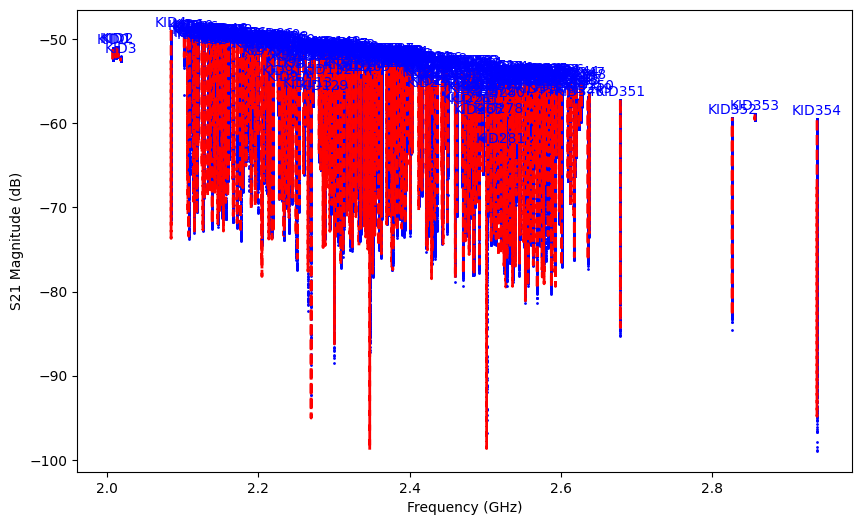

In [3]:

fits_vna_sweep = FitsFileLoadService.load_fits_vna_sweep_file(file_path=idc_file_path)
frequency_array = fits_vna_sweep.data.frequency_array
s21_complex = fits_vna_sweep.data.get_iq_array()

number_of_tones = fits_vna_sweep.header.number_of_tones
print(f"Number of KID tones: {number_of_tones}")
fits_vna_sweep.header.print_attenuation_values()

# Split data into sub arrays corresponding to each kid:
frequency_array = np.split(frequency_array, number_of_tones)
s21_magnitude = np.abs(np.split(s21_complex, number_of_tones))

idc_f0_array = []
idc_qr_array = []
idc_qc_array = []
idc_qi_array = []

plt.figure(figsize=(10, 6))
for count, kid_s21 in enumerate(s21_magnitude):
    plt.plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(kid_s21),
        linestyle="none",
        marker="o",
        color="b",
        markersize="1",
    )
    if show_kid_labels:
        plt.text(
            np.median(frequency_array[count]) * 1e-9,
            np.max(20 * np.log10(kid_s21)) + 0.5,
            f"KID{count}",
            fontsize=10,
            color="b",
            horizontalalignment="center",
        )

    # TODO: Add logic to rerun fit with different Q if errors are too large.
    if fit_model == "skewed":
        fit_result_dict = lekid_analysis_tools.fit_skewed_lorentzian(
            frequency_array=frequency_array[count],
            data_array=kid_s21,
            qc_guess=1e5,
            qi_guess=1e5,
            f0_guess=None,
            fit_fraction=0.9,
            normalise=False,
            plot_db=True,
            plot_title=f"Skewed (Pete fitter) fit: KID {count}",
            plot_graph=False,
        )
        s21_fit = lekid_analysis_tools.skewed_lorentzian(
            frequency_array=frequency_array[count],
            f0=fit_result_dict["f0"][0],
            qi=fit_result_dict["qi"][0],
            qc_real=fit_result_dict["qc_real"][0],
            qc_imag=fit_result_dict["qc_imag"][0],
            amp=fit_result_dict["amp"][0],
        )
        plt.plot(
            frequency_array[count] * 1e-9,
            20 * np.log10(s21_fit),
            linewidth=2,
            linestyle="--",
            color="r",
        )

        if fit_result_dict["qi"][0] > 1e6:
            qi = fit_result_dict["qi"][0]
            print(f"KID{count}: Qi = {qi:.2E}")

    # Store f0 and quality factor data.
    idc_f0_array.append(fit_result_dict["f0"][0])
    idc_qr_array.append(fit_result_dict["qr"][0])
    idc_qc_array.append(fit_result_dict["qc"][0])
    idc_qi_array.append(fit_result_dict["qi"][0])

plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 Magnitude (dB)")
plt.show()

idc_f0_array = np.array(idc_f0_array)
idc_qr_array = np.array(idc_qr_array)
idc_qc_array = np.array(idc_qc_array)
idc_qi_array = np.array(idc_qi_array)


Sweep Data Missing Field: SETBASET
Number of KID tones: 348
Data file attenuation values:
Room temperature attenuation = 2.0
Variable Room temperature attenuation = 52.0dB
Cold attenuation = 20.0dB
Ultra-cold attenuation = 10.0dB
Output attenuation = 0.0dB
Total Amplifier Gain = 0dB
KID287: Qi = 3.39E+06


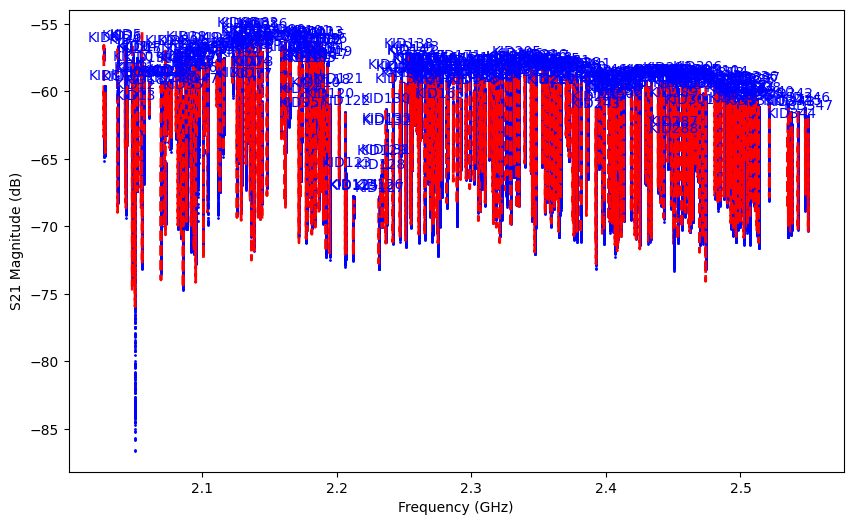

In [4]:

fits_vna_sweep = FitsFileLoadService.load_fits_vna_sweep_file(file_path=ppc_file_path)
frequency_array = fits_vna_sweep.data.frequency_array
s21_complex = fits_vna_sweep.data.get_iq_array()

number_of_tones = fits_vna_sweep.header.number_of_tones
print(f"Number of KID tones: {number_of_tones}")
fits_vna_sweep.header.print_attenuation_values()

# Split data into sub arrays corresponding to each kid:
frequency_array = np.split(frequency_array, number_of_tones)
s21_magnitude = np.abs(np.split(s21_complex, number_of_tones))

ppc_f0_array = []
ppc_qr_array = []
ppc_qc_array = []
ppc_qi_array = []

plt.figure(figsize=(10, 6))
for count, kid_s21 in enumerate(s21_magnitude):
    plt.plot(
        frequency_array[count] * 1e-9,
        20 * np.log10(kid_s21),
        linestyle="none",
        marker="o",
        color="b",
        markersize="1",
    )
    if show_kid_labels:
        plt.text(
            np.median(frequency_array[count]) * 1e-9,
            np.max(20 * np.log10(kid_s21)) + 0.5,
            f"KID{count}",
            fontsize=10,
            color="b",
            horizontalalignment="center",
        )

    # TODO: Add logic to rerun fit with different Q if errors are too large.
    if fit_model == "skewed":
        fit_result_dict = lekid_analysis_tools.fit_skewed_lorentzian(
            frequency_array=frequency_array[count],
            data_array=kid_s21,
            qc_guess=1e5,
            qi_guess=1e5,
            f0_guess=None,
            fit_fraction=0.9,
            normalise=False,
            plot_db=True,
            plot_title=f"Skewed (Pete fitter) fit: KID {count}",
            plot_graph=False,
        )
        s21_fit = lekid_analysis_tools.skewed_lorentzian(
            frequency_array=frequency_array[count],
            f0=fit_result_dict["f0"][0],
            qi=fit_result_dict["qi"][0],
            qc_real=fit_result_dict["qc_real"][0],
            qc_imag=fit_result_dict["qc_imag"][0],
            amp=fit_result_dict["amp"][0],
        )
        plt.plot(
            frequency_array[count] * 1e-9,
            20 * np.log10(s21_fit),
            linewidth=2,
            linestyle="--",
            color="r",
        )

        if fit_result_dict["qi"][0] > 1e6:
            qi = fit_result_dict["qi"][0]
            print(f"KID{count}: Qi = {qi:.2E}")

    # Store f0 and quality factor data.
    ppc_f0_array.append(fit_result_dict["f0"][0])
    ppc_qr_array.append(fit_result_dict["qr"][0])
    ppc_qc_array.append(fit_result_dict["qc"][0])
    ppc_qi_array.append(fit_result_dict["qi"][0])

plt.xlabel("Frequency (GHz)")
plt.ylabel("S21 Magnitude (dB)")
plt.show()

ppc_f0_array = np.array(ppc_f0_array)
ppc_qr_array = np.array(ppc_qr_array)
ppc_qc_array = np.array(ppc_qc_array)
ppc_qi_array = np.array(ppc_qi_array)


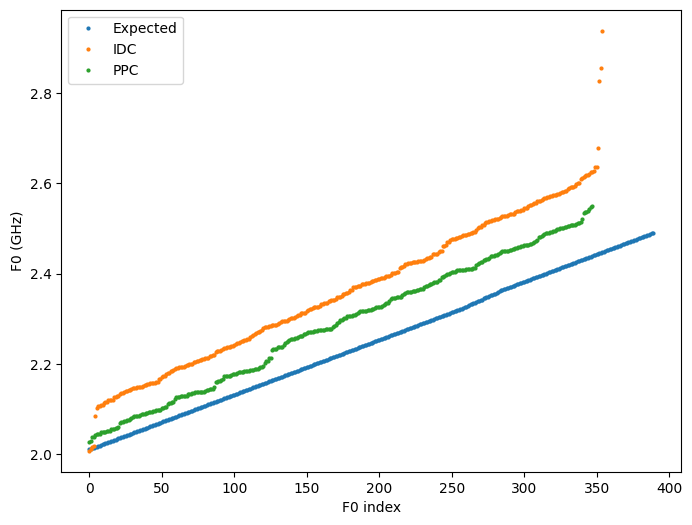

In [5]:
expected_f0_array = np.sort(np.concatenate(np.loadtxt(expected_f0_filepath, delimiter=",")))
n_tones_expected = expected_f0_array.size

plt.figure(figsize=(8, 6))
plt.plot(expected_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="Expected")
plt.plot(idc_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="IDC")
plt.plot(ppc_f0_array*1e-9, linestyle="none", marker="o", markersize=2, label="PPC")
plt.xlabel("F0 index")
plt.ylabel("F0 (GHz)")
plt.legend()
plt.show()

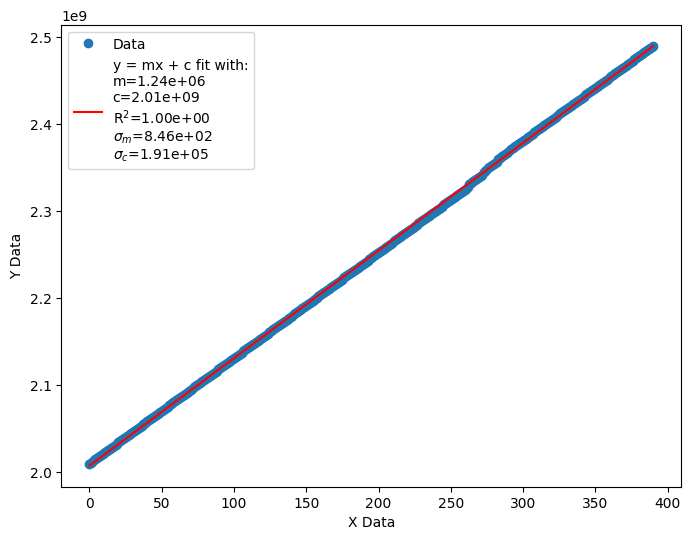

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


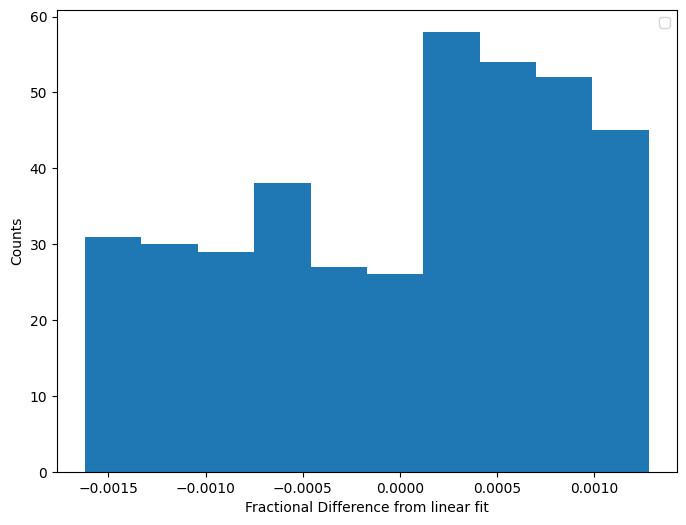

In [13]:
import source.util.general_analysis_tools as general_analysis_tools

n_bins = 10

index_values = np.linspace(0, expected_f0_array.size, expected_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    expected_f0_array,
    plot_graph=True
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
fractional_difference = (expected_f0_array - best_fit) / best_fit

difference_density, difference_bins = np.histogram(fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


result = model.fit(difference_density, parameters, x=bin_centres)
result_dict = {}
for name, parameter in result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(fractional_difference, density=False, bins=n_bins)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Counts")
plt.legend()
plt.show()

In [7]:
idc_mask = np.where((idc_f0_array > 2.1e9) & (idc_f0_array < 2.635e9))[0]
ppc_mask = np.where((ppc_f0_array > 2.23e9) & (ppc_f0_array < 2.51e9))[0]

reduced_idc_f0_array = idc_f0_array[idc_mask]
reduced_ppc_f0_array = ppc_f0_array[ppc_mask]

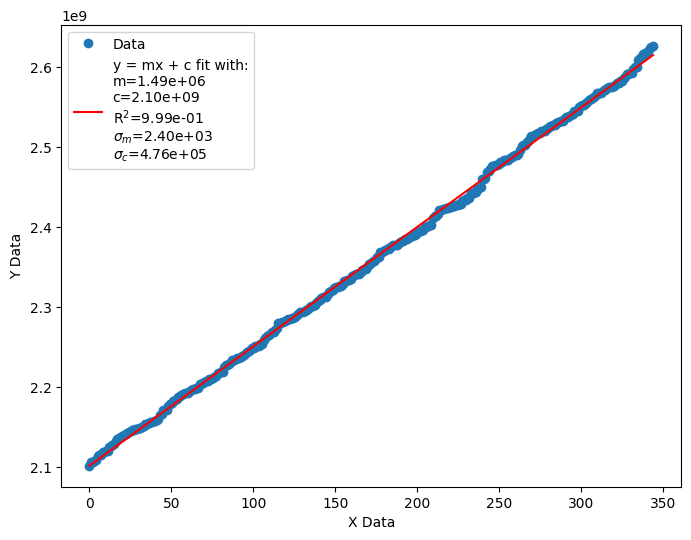

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


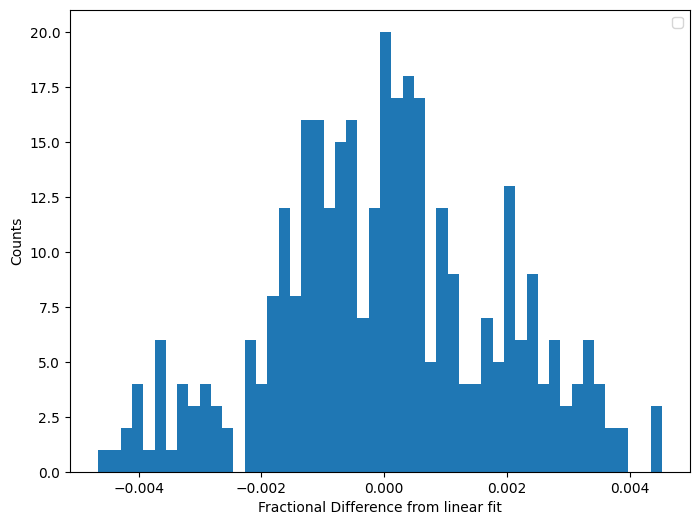

In [24]:
n_bins = 50

index_values = np.linspace(0, reduced_idc_f0_array.size, reduced_idc_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_idc_f0_array,
    plot_graph=True
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
idc_fractional_difference = (reduced_idc_f0_array - best_fit) / best_fit

idc_difference_density, idc_difference_bins = np.histogram(idc_fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


idc_result = model.fit(difference_density, parameters, x=bin_centres)
result_dict = {}
for name, parameter in idc_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(idc_fractional_difference, density=False, bins=n_bins)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Counts")
plt.legend()
plt.show()

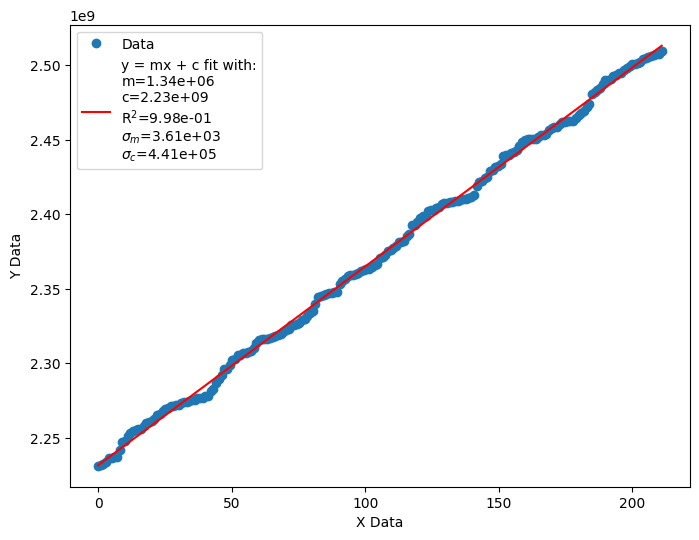

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


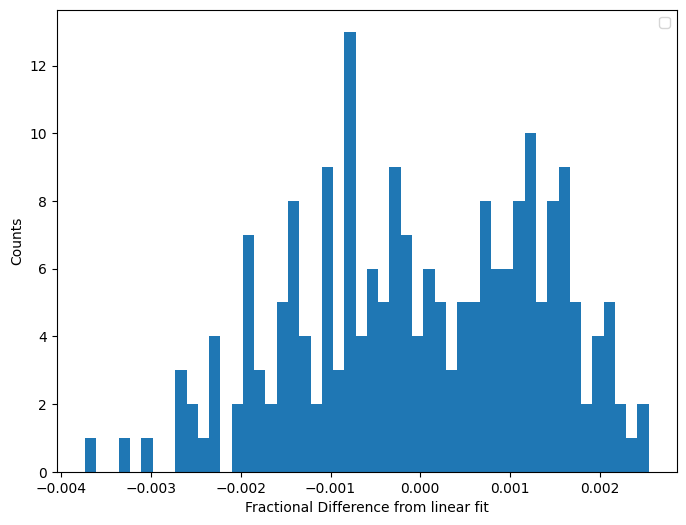

In [30]:
n_bins = 50

index_values = np.linspace(0, reduced_ppc_f0_array.size, reduced_ppc_f0_array.size)
linear_fit = general_analysis_tools.fit_linear_regression(
    index_values,
    reduced_ppc_f0_array,
    plot_graph=True
)

best_fit = linear_fit.slope * index_values + linear_fit.intercept
ppc_fractional_difference = (reduced_ppc_f0_array - best_fit) / best_fit

ppc_difference_density, ppc_difference_bins = np.histogram(ppc_fractional_difference, density=False, bins=n_bins)
bin_centres = difference_bins[:-1] + (difference_bins[1] - difference_bins[0]) / 2

# Fit gaussian:
model = GaussianModel()
# parameters = model.guess(difference_density, x=bin_centres)
parameters = Parameters()
parameters.add("sigma", value=4.0, vary=True)
parameters.add("center", value=0, vary=True)
parameters.add("amplitude", value=1.0, vary=True)


ppc_result = model.fit(difference_density, parameters, x=bin_centres)
result_dict = {}
for name, parameter in ppc_result.params.items():
    result_dict[name] = [parameter.value, parameter.stderr]
ffs_sigma=float(result_dict["sigma"][0])
ffs_centre=float(result_dict["center"][0])
ffs_sigma_error=float(result_dict["sigma"][1])
ffs_centre_error=float(result_dict["center"][1])


plt.figure(figsize=(8, 6))
plt.hist(ppc_fractional_difference, density=False, bins=n_bins)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Counts")
plt.legend()
plt.show()

[ 1  1  2  4  1  6  1  4  3  4  3  2  0  6  4  8 12  8 16 16 12 15 16  7
 12 20 17 18 17  5 12  9  4  4  7  5 13  6  9  4  6  3  4  6  4  2  2  0
  0  3]


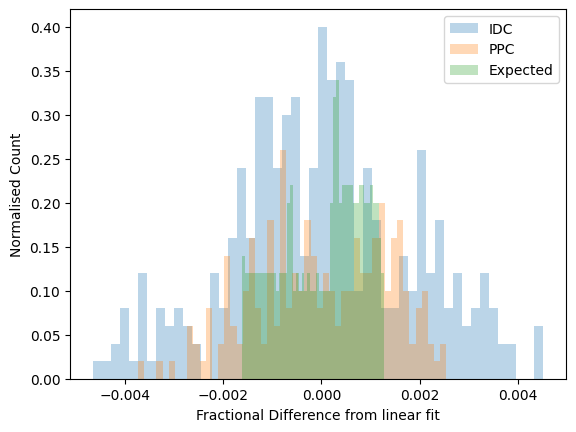

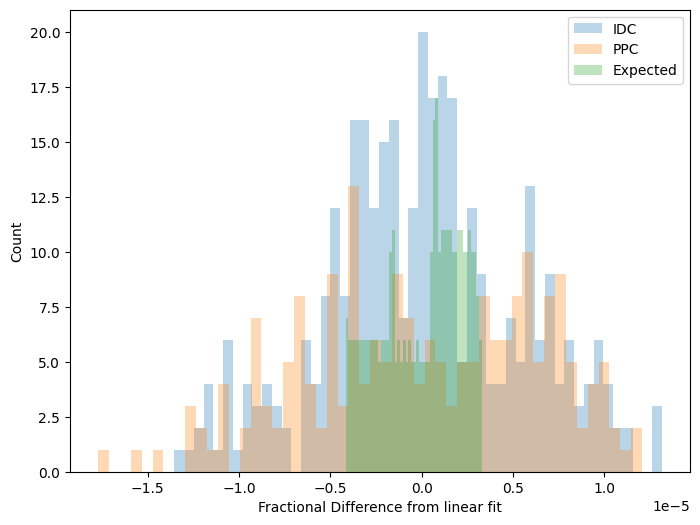

In [33]:
n_bins = 50

idc_difference, idc_difference_bins = np.histogram(idc_fractional_difference, density=False, bins=n_bins)
idc_bin_centres = idc_difference_bins[:-1] + (idc_difference_bins[1] - idc_difference_bins[0]) / 2

ppc_difference, ppc_difference_bins = np.histogram(ppc_fractional_difference, density=False, bins=n_bins)
ppc_bin_centres = ppc_difference_bins[:-1] + (ppc_difference_bins[1] - ppc_difference_bins[0]) / 2

expected_difference, expected_difference_bins = np.histogram(fractional_difference, density=False, bins=n_bins)
expected_bin_centres = expected_difference_bins[:-1] + (expected_difference_bins[1] - expected_difference_bins[0]) / 2

print(idc_difference)
plt.figure()
plt.bar(idc_bin_centres, height=idc_difference/len(idc_difference), width=idc_bin_centres[1] - idc_bin_centres[0], label="IDC", alpha=0.3)
plt.bar(ppc_bin_centres, height=ppc_difference/len(ppc_difference), width=ppc_bin_centres[1] - ppc_bin_centres[0], label="PPC", alpha=0.3)
plt.bar(expected_bin_centres, height=expected_difference/len(expected_difference), width=expected_bin_centres[1] - expected_bin_centres[0], label="Expected", alpha=0.3)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Normalised Count")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(idc_fractional_difference / len(reduced_idc_f0_array), density=False, bins=n_bins, label="IDC", alpha=0.3)
plt.hist(ppc_fractional_difference / len(reduced_ppc_f0_array), density=False, bins=n_bins, label="PPC", alpha=0.3)
plt.hist(fractional_difference / len(expected_f0_array), density=False, bins=n_bins, label="Expected", alpha=0.3)
plt.xlabel("Fractional Difference from linear fit")
plt.ylabel("Count")
plt.legend()
plt.show(f"Histogram of fractional difference to linear fit in {n_bins} bins")
plt.show()